In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Dataset

Tiny Lego dataset
- https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz

In [ ]:
if not os.path.exists("tiny_nerf_data.npz"):
  !wget https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz

dataset = np.load("tiny_nerf_data.npz")
print(dataset["images"].shape)
print(dataset["poses"].shape)
print(dataset['focal'])
fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(30,4))
for i, ax in enumerate(axs.flatten()):
    plt.sca(ax)
    plt.imshow(dataset['images'][i])
    plt.title('Image: {}'.format(i+1))
    plt.axis("off")

# Data Loading (Pinhole Camera Model)




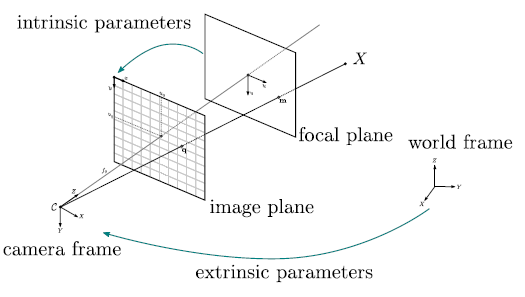

In [ ]:
poses = dataset['poses']
dirs = np.stack([np.sum([0, 0, -1] * pose[:3, :3], axis=-1) for pose in poses])
origins = poses[:, :3, 3]

ax = plt.figure(figsize=(12,8)).add_subplot(projection="3d")
_ = ax.quiver(
    origins[..., 0].flatten(),
    origins[..., 1].flatten(),
    origins[..., 2].flatten(),
    dirs[..., 0].flatten(),
    dirs[..., 1].flatten(),
    dirs[..., 2].flatten(), length=0.5, normalize=True
)
plt.show()

# Functions

- get_rays


In [ ]:
def get_rays(h: int, w: int, focal_length: float, pose: torch.Tensor):
  i, j = torch.meshgrid(
      torch.arange(w, dtype=torch.float32).to(pose),
      torch.arange(h, dtype=torch.float32).to(pose),
      indexing='ij')
  i, j = i.transpose(-1, -2), j.transpose(-1, -2)
  rays_d = torch.stack([(i - w * .5) / focal_length,
                            -(j - h * .5) / focal_length,
                            -torch.ones_like(i)
                           ], dim=-1)
  rays_d = torch.sum(rays_d[..., None, :] * pose[:3, :3], dim=-1)
  rays_o = pose[:3, -1].expand(rays_d.shape)
  return rays_o, rays_d


- stratified_sampling

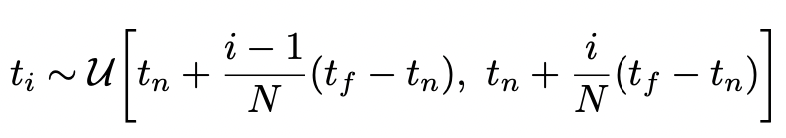


In [ ]:
def stratified_sampling(
    rays_o,
    rays_d,
    near,
    far,
    n,
):
  # shape: (num_samples)
  t = torch.linspace(near, far, n).to(rays_o)
  
  # ray_origins: (width, height, 3)
  # noise_shape = (width, height, num_samples)
  noise_shape = list(rays_o.shape[:-1]) + [n]
  
  # depth_values: (num_samples)
  t = t + torch.rand(noise_shape).to(rays_o) * (far - near) / n
  
  # (width, height, num_samples, 3) = (width, height, 1, 3) + (width, height, 1, 3) * (num_samples, 1)
  # query_points:  (width, height, num_samples, 3)
  x = rays_o[..., None, :] + rays_d[..., None, :] * t[..., :, None]
  
  return x, t

- positional encoding
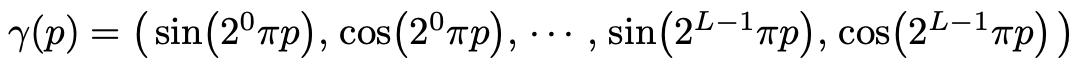

In [ ]:
def positional_encoding(
    x, L=6, include_input=True
) -> torch.Tensor:
  encoding = [x] if include_input else []
  frequency_bands = 2.0 ** torch.linspace(
        0.0,
        L - 1,
        L,
        dtype=x.dtype,
        device=x.device,
  )
  for freq in frequency_bands:
    encoding.append(torch.sin(x * freq * np.pi))
    encoding.append(torch.cos(x * freq * np.pi))
  
  return torch.cat(encoding, dim=-1)

- volume_rendering
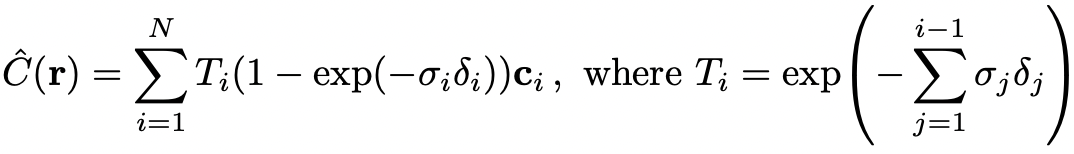

In [ ]:
## TODO 1.
def volume_rendering(c, sigma, rays_o, t):
  sigma = torch.nn.functional.relu(sigma)[...,0]
  c = torch.sigmoid(c)
  delta = t[..., 1:] - t[..., :-1]
  delta = torch.cat([delta, torch.tensor([1e10], dtype=rays_o.dtype, device=rays_o.device).expand(t[...,:1].shape)], dim=-1)

  alpha = 1. - torch.exp(-sigma * delta)
  T = torch.cumprod(1. - alpha + 1e-10, -1)
  T = torch.roll(T, 1, -1)
  T[..., 0] = 1.

  w = T * alpha

  rgb = (w[..., None] * c).sum(dim=-2)
  return rgb

# Model

In [ ]:
class NeRFSmall(nn.Module):
    def __init__(self,
                 num_layers=3,
                 hidden_dim=64,
                 geo_feat_dim=15,
                 num_layers_color=4,
                 hidden_dim_color=64,
                 input_ch=3, input_ch_views=3,
                 ):
        super(NeRFSmall, self).__init__()

        self.input_ch = input_ch
        self.input_ch_views = input_ch_views

        # sigma network
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.geo_feat_dim = geo_feat_dim

        sigma_net = []
        for l in range(num_layers):
            if l == 0:
                in_dim = self.input_ch
            else:
                in_dim = hidden_dim
            
            if l == num_layers - 1:
                out_dim = 1 + self.geo_feat_dim # 1 sigma + 15 SH features for color
            else:
                out_dim = hidden_dim
            
            sigma_net.append(nn.Linear(in_dim, out_dim, bias=False))

        self.sigma_net = nn.ModuleList(sigma_net)

        # color network
        self.num_layers_color = num_layers_color        
        self.hidden_dim_color = hidden_dim_color
        
        color_net =  []
        for l in range(num_layers_color):
            if l == 0:
                in_dim = self.input_ch_views + self.geo_feat_dim
            else:
                in_dim = hidden_dim
            
            if l == num_layers_color - 1:
                out_dim = 3 # 3 rgb
            else:
                out_dim = hidden_dim
            
            color_net.append(nn.Linear(in_dim, out_dim, bias=False))

        self.color_net = nn.ModuleList(color_net)
    
    def forward(self, x):
        input_pts, input_views = torch.split(x, [self.input_ch, self.input_ch_views], dim=-1)

        # sigma
        h = input_pts
        for l in range(self.num_layers):
            h = self.sigma_net[l](h)
            if l != self.num_layers - 1:
                h = F.relu(h, inplace=True)

        sigma, geo_feat = h[..., 0], h[..., 1:]
        
        # color
        h = torch.cat([input_views, geo_feat], dim=-1)
        for l in range(self.num_layers_color):
            h = self.color_net[l](h)
            if l != self.num_layers_color - 1:
                h = F.relu(h, inplace=True)

        color = h
        outputs = torch.cat([color, sigma.unsqueeze(dim=-1)], -1)

        return outputs

In [ ]:

BOX_OFFSETS = torch.tensor([[[i,j,k] for i in [0, 1] for j in [0, 1] for k in [0, 1]]],
                               device='cuda')

def hash(coords, log2_hashmap_size):
    primes = [1, 2654435761, 805459861, 3674653429, 2097192037, 1434869437, 2165219737]

    xor_result = torch.zeros_like(coords)[..., 0]
    for i in range(coords.shape[-1]):
        xor_result ^= coords[..., i]*primes[i]

    return torch.tensor((1<<log2_hashmap_size)-1).to(xor_result.device) & xor_result

def get_voxel_vertices(xyz, bounding_box, resolution, log2_hashmap_size):
    box_min, box_max = bounding_box

    if not torch.all(xyz <= box_max) or not torch.all(xyz >= box_min):
        xyz = torch.clamp(xyz, min=box_min, max=box_max)

    grid_size = (box_max-box_min)/resolution
    
    bottom_left_idx = torch.floor((xyz-box_min)/grid_size).int()
    voxel_min_vertex = bottom_left_idx*grid_size + box_min
    voxel_max_vertex = voxel_min_vertex + torch.tensor([1.0,1.0,1.0]).to(xyz)*grid_size

    voxel_indices = bottom_left_idx.unsqueeze(1) + BOX_OFFSETS
    hashed_voxel_indices = hash(voxel_indices, log2_hashmap_size)

    return voxel_min_vertex, voxel_max_vertex, hashed_voxel_indices

class HashEmbedder(nn.Module):
    def __init__(self, bounding_box, n_levels=16, n_features_per_level=2,\
                log2_hashmap_size=19, base_resolution=16, finest_resolution=512):
        super(HashEmbedder, self).__init__()
        self.bounding_box = bounding_box
        self.n_levels = n_levels
        self.n_features_per_level = n_features_per_level
        self.log2_hashmap_size = log2_hashmap_size
        self.base_resolution = torch.tensor(base_resolution)
        self.finest_resolution = torch.tensor(finest_resolution)
        self.out_dim = self.n_levels * self.n_features_per_level

        self.b = torch.exp((torch.log(self.finest_resolution)-torch.log(self.base_resolution))/(n_levels-1))

        self.embeddings = nn.ModuleList([nn.Embedding(2**self.log2_hashmap_size, \
                                        self.n_features_per_level) for i in range(n_levels)])
        # custom uniform initialization
        for i in range(n_levels):
            nn.init.uniform_(self.embeddings[i].weight, a=-0.0001, b=0.0001)
            # self.embeddings[i].weight.data.zero_()
        

    def trilinear_interp(self, x, voxel_min_vertex, voxel_max_vertex, voxel_embedds):
        '''
        x: B x 3
        voxel_min_vertex: B x 3
        voxel_max_vertex: B x 3
        voxel_embedds: B x 8 x 2
        '''
        # source: https://en.wikipedia.org/wiki/Trilinear_interpolation
        weights = (x - voxel_min_vertex)/(voxel_max_vertex-voxel_min_vertex) # B x 3

        # step 1
        # 0->000, 1->001, 2->010, 3->011, 4->100, 5->101, 6->110, 7->111
        c00 = voxel_embedds[:,0]*(1-weights[:,0][:,None]) + voxel_embedds[:,4]*weights[:,0][:,None]
        c01 = voxel_embedds[:,1]*(1-weights[:,0][:,None]) + voxel_embedds[:,5]*weights[:,0][:,None]
        c10 = voxel_embedds[:,2]*(1-weights[:,0][:,None]) + voxel_embedds[:,6]*weights[:,0][:,None]
        c11 = voxel_embedds[:,3]*(1-weights[:,0][:,None]) + voxel_embedds[:,7]*weights[:,0][:,None]

        # step 2
        c0 = c00*(1-weights[:,1][:,None]) + c10*weights[:,1][:,None]
        c1 = c01*(1-weights[:,1][:,None]) + c11*weights[:,1][:,None]

        # step 3
        c = c0*(1-weights[:,2][:,None]) + c1*weights[:,2][:,None]

        return c

    def forward(self, x):
        # x is 3D point position: B x 3
        x_embedded_all = []
        for i in range(self.n_levels):
            resolution = torch.floor(self.base_resolution * self.b**i)
            voxel_min_vertex, voxel_max_vertex, hashed_voxel_indices = get_voxel_vertices(\
                                                x, self.bounding_box, \
                                                resolution, self.log2_hashmap_size)
            
            voxel_embedds = self.embeddings[i](hashed_voxel_indices)

            x_embedded = self.trilinear_interp(x, voxel_min_vertex, voxel_max_vertex, voxel_embedds)
            x_embedded_all.append(x_embedded)

        return torch.cat(x_embedded_all, dim=-1)

class SHEncoder(nn.Module):
    def __init__(self, input_dim=3, degree=4):
    
        super().__init__()

        self.input_dim = input_dim
        self.degree = degree

        assert self.input_dim == 3
        assert self.degree >= 1 and self.degree <= 5

        self.out_dim = degree ** 2

        self.C0 = 0.28209479177387814
        self.C1 = 0.4886025119029199
        self.C2 = [
            1.0925484305920792,
            -1.0925484305920792,
            0.31539156525252005,
            -1.0925484305920792,
            0.5462742152960396
        ]
        self.C3 = [
            -0.5900435899266435,
            2.890611442640554,
            -0.4570457994644658,
            0.3731763325901154,
            -0.4570457994644658,
            1.445305721320277,
            -0.5900435899266435
        ]
        self.C4 = [
            2.5033429417967046,
            -1.7701307697799304,
            0.9461746957575601,
            -0.6690465435572892,
            0.10578554691520431,
            -0.6690465435572892,
            0.47308734787878004,
            -1.7701307697799304,
            0.6258357354491761
        ]

    def forward(self, input, **kwargs):

        result = torch.empty((*input.shape[:-1], self.out_dim), dtype=input.dtype, device=input.device)
        x, y, z = input.unbind(-1)

        result[..., 0] = self.C0
        if self.degree > 1:
            result[..., 1] = -self.C1 * y
            result[..., 2] = self.C1 * z
            result[..., 3] = -self.C1 * x
            if self.degree > 2:
                xx, yy, zz = x * x, y * y, z * z
                xy, yz, xz = x * y, y * z, x * z
                result[..., 4] = self.C2[0] * xy
                result[..., 5] = self.C2[1] * yz
                result[..., 6] = self.C2[2] * (2.0 * zz - xx - yy)
                #result[..., 6] = self.C2[2] * (3.0 * zz - 1) # xx + yy + zz == 1, but this will lead to different backward gradients, interesting...
                result[..., 7] = self.C2[3] * xz
                result[..., 8] = self.C2[4] * (xx - yy)
                if self.degree > 3:
                    result[..., 9] = self.C3[0] * y * (3 * xx - yy)
                    result[..., 10] = self.C3[1] * xy * z
                    result[..., 11] = self.C3[2] * y * (4 * zz - xx - yy)
                    result[..., 12] = self.C3[3] * z * (2 * zz - 3 * xx - 3 * yy)
                    result[..., 13] = self.C3[4] * x * (4 * zz - xx - yy)
                    result[..., 14] = self.C3[5] * z * (xx - yy)
                    result[..., 15] = self.C3[6] * x * (xx - 3 * yy)
                    if self.degree > 4:
                        result[..., 16] = self.C4[0] * xy * (xx - yy)
                        result[..., 17] = self.C4[1] * yz * (3 * xx - yy)
                        result[..., 18] = self.C4[2] * xy * (7 * zz - 1)
                        result[..., 19] = self.C4[3] * yz * (7 * zz - 3)
                        result[..., 20] = self.C4[4] * (zz * (35 * zz - 30) + 3)
                        result[..., 21] = self.C4[5] * xz * (7 * zz - 3)
                        result[..., 22] = self.C4[6] * (xx - yy) * (7 * zz - 1)
                        result[..., 23] = self.C4[7] * xz * (xx - 3 * yy)
                        result[..., 24] = self.C4[8] * (xx * (xx - 3 * yy) - yy * (3 * xx - yy))

        return result

def get_bbox3d_for_blenderobj(focal, poses, H, W, near=2.0, far=6.0):
    min_bound = [100, 100, 100]
    max_bound = [-100, -100, -100]

    for pose in poses:
        rays_o, rays_d = get_rays(H, W, focal, pose)
        rays_o, rays_d = rays_o.reshape(-1, 3), rays_d.reshape(-1, 3)
        def find_min_max(pt):
            for i in range(3):
                if(min_bound[i] > pt[i]):
                    min_bound[i] = pt[i]
                if(max_bound[i] < pt[i]):
                    max_bound[i] = pt[i]
            return
     
        for i in [0, W-1, H*W-W, H*W-1]:
            min_point = rays_o[i] + near*rays_d[i]
            max_point = rays_o[i] + far*rays_d[i]
            find_min_max(min_point)
            find_min_max(max_point)

    return ((torch.tensor(min_bound)-torch.tensor([1.0,1.0,1.0])).to(poses), (torch.tensor(max_bound)+torch.tensor([1.0,1.0,1.0])).to(poses))

# Prepare dataset 



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

images = dataset['images']
poses = dataset['poses']
focal_length = dataset['focal']

num_images, h, w = images.shape[:3]
test_idx = 101
test_image = images[test_idx]
test_pose = poses[test_idx]

images = torch.from_numpy(images[:100, ... ,:3]).to(device)
poses = torch.from_numpy(poses).to(device)
focal_length = torch.from_numpy(focal_length).to(device)

# Training

### 1. define hyperparameters

In [ ]:
# number of emb
L_x = 10
L_d = 4

N_c = 32

lr = 5e-4
num_iters = 10000
num_channels = 128
num_layers = 8
skip = 4

display_every = 1000

near = 2. 
far = 6. 

batch_size = 4 * 1024

log2_hashmap_size = 19
finest_res = 512

### 2. Implement single training iteration 

In [ ]:
def train_step(h, w, focal_length, pose, near, far, n_c, embed_fn, embeddir_fn):

  rays_o, rays_d = get_rays(h, w, focal_length, pose)

  x, t = stratified_sampling(rays_o, rays_d, near, far, n_c)

  # (width, height, n_c, 3)
  # (widht * height * n_c, 3)
  x_flatten = x.reshape(-1, 3)
  d_flatten = rays_d[..., None, :].expand_as(x).reshape(-1, 3)

  embedded = embed_fn(x_flatten)
  embedded = torch.cat([embedded, embeddir_fn(d_flatten)], dim=-1)
  
  pred = []
  for i in range(0, embedded.shape[0], batch_size):
    pred.append(model(embedded[i:i+batch_size]))
  pred = torch.cat(pred, dim=0).reshape(h, w, -1, 4)
  
  colors = pred[..., :3]
  sigma = pred[..., 3].reshape(h,w, -1, 1)
  rgb = volume_rendering(colors, sigma, rays_o, t)
  return rgb

### 3. Start training

In [ ]:
bounding_box = get_bbox3d_for_blenderobj(focal_length, poses, h, w, near, far)
log2_hashmap_size = 16
finest_res = 512

embed_fn = HashEmbedder(bounding_box=bounding_box, log2_hashmap_size=log2_hashmap_size, finest_resolution=finest_res)
input_dim_x = embed_fn.out_dim
embeddirs_fn = SHEncoder()
input_dim_d = embeddirs_fn.out_dim

embed_fn = embed_fn.to(device)
embeddirs_fn = embeddirs_fn.to(device)

model = NeRFSmall(num_layers=2,
                  hidden_dim=64,
                  geo_feat_dim=15,
                  num_layers_color=3,
                  hidden_dim_color=64,
                  input_ch=input_dim_x, input_ch_views=input_dim_d).to(device)

optimizer = torch.optim.Adam([{
    'params': model.parameters(), 'lr': lr, 'weight_decay': 1e-6}, {'params': embed_fn.parameters(), 'lr': lr}], eps=1e-15)

seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

pbar = tqdm(range(num_iters))
for i in pbar:
  idx = np.random.randint(images.shape[0])
  image_i = images[idx]
  pose_i = poses[idx]

  rgb_predicted = train_step(h, w, focal_length, pose_i, near, far, N_c, embed_fn, embeddirs_fn)
  
  loss = torch.nn.functional.mse_loss(rgb_predicted, image_i)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  pbar.set_postfix({"loss": loss.item()})

  if i % display_every == 0:
    rgb_predicted = train_step(h, w, focal_length, torch.from_numpy(test_pose).to(device), near, far, N_c, embed_fn, embeddirs_fn)

    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.imshow(rgb_predicted.detach().cpu().numpy())

    plt.subplot(122)
    plt.imshow(test_image)
    plt.title(f"Iteration {i}")
    plt.show()